In [1]:
# Step 1: Import libraries
import pandas as pd
import os
import sys
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 2: Load the dataset
# Replace 'your_file.xlsx' with the actual file name/path
df = pd.read_csv("/Users/vijeethvj8/Documents/Kaggle projects/REALTOR/realtor-data.csv")

# Step 3: Quick checks
print("Shape of dataset:", df.shape)   # rows, columns
print("\nColumn names and data types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Step 4: Preview first few rows
#df.head(1)
df.columns

Shape of dataset: (2226382, 12)

Column names and data types:
 brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

Missing values per column:
 brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64


Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

In [3]:
# 1) Helper: safe ZIP formatting (keep NaNs)
def _fmt_zip(z):
    if pd.isna(z): 
        return pd.NA
    try:
        # zip loaded as float -> round (should be integer-like), then pad
        z_int = int(round(float(z)))
        # US ZIP: zero-pad to 5 if <= 5 digits; keep longer as-is
        s = str(z_int)
        return s.zfill(5) if len(s) <= 5 else s
    except Exception:
        return pd.NA

# 2) Cast likely categorical/text fields to string dtype (nullable)
for col in ["brokered_by", "street", "city", "state", "status"]:
    if col in df.columns:
        # keep NA as <NA>, strip whitespace
        df[col] = (df[col]
                   .astype("string")
                   .str.strip())

# 3) Normalize common text columns
if "state" in df.columns:
    df["state"] = df["state"].str.upper()
if "city" in df.columns:
    # Title Case but keep NA
    df["city"] = df["city"].str.title()
if "status" in df.columns:
    df["status"] = df["status"].str.title()

# 4) ZIP code: format and keep as string (nullable)
if "zip_code" in df.columns:
    df["zip_code"] = df["zip_code"].apply(_fmt_zip).astype("string")

# 5) Parse dates
if "prev_sold_date" in df.columns:
    df["prev_sold_date"] = pd.to_datetime(df["prev_sold_date"], errors="coerce")

# 6) Ensure numeric coercion where applicable
for col in ["price", "bed", "bath", "acre_lot", "house_size"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 7) Memory usage (rough)
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"\nApprox. memory usage: {mem_mb:,.2f} MB")

# 8) Missing values (post-clean)
na = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column (post-clean):\n", na)

# 9) Numeric summary with missing %
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
if num_cols:
    desc = df[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
    desc["missing"] = df[num_cols].isna().sum()
    desc["missing_pct"] = (desc["missing"] / len(df) * 100).round(2)
    print("\nNumeric summary (with missing %):\n", desc)

# 10) Categorical peek (top 10 by frequency)
cat_cols = df.select_dtypes(include=["string","object","category"]).columns.tolist()
show_top = 10
for c in ["status", "state", "city", "brokered_by"]:
    if c in cat_cols:
        vc = df[c].value_counts(dropna=False).head(show_top)
        print(f"\nTop {show_top} values for '{c}':\n{vc}")

# 11) Quick sanity checks
print("\nDtypes after cleaning:\n", df.dtypes)


Approx. memory usage: 922.51 MB

Missing values per column (post-clean):
 prev_sold_date    734298
house_size        568484
bath              511771
bed               481317
acre_lot          325589
street             10866
brokered_by         4533
price               1541
city                1407
zip_code             299
state                  8
status                 0
dtype: int64

Numeric summary (with missing %):
                 count           mean           std  min        1%        5%  \
price       2224841.0  524195.519291  2.138893e+06  0.0  10000.00  30000.00   
bed         1745065.0       3.275841  1.567274e+00  1.0      1.00      2.00   
bath        1714611.0       2.496440  1.652573e+00  1.0      1.00      1.00   
acre_lot    1900793.0      15.223027  7.628238e+02  0.0      0.02      0.05   
house_size  1657898.0    2714.471335  8.081635e+05  4.0    598.00    847.00   

                  25%        50%        75%         95%         99%  \
price       165000.00  325000.

In [5]:
# =========================
# Outlier Filtering + State Summary
# =========================

# 1) Outlier filters (set thresholds)
df_clean = df.copy()
df_clean = df_clean[
    (df_clean["price"].between(10_000, 10_000_000)) &  # filter price 10K–10M
    (df_clean["bed"].between(0, 15)) &                 # cap beds at 15
    (df_clean["bath"].between(0, 15)) &                # cap baths at 15
    (df_clean["house_size"].between(200, 20_000)) &    # sq ft reasonable
    (df_clean["acre_lot"].between(0, 1000))            # cap acreage
]

print(f"After filtering: {len(df_clean):,} rows (from {len(df):,})")

# 2) State-level summary
state_summary = (
    df_clean.groupby("state")
    .agg(
        median_price=("price","median"),
        median_bed=("bed","median"),
        median_bath=("bath","median"),
        median_size=("house_size","median"),
        median_acre=("acre_lot","median"),
        count=("price","size")
    )
    .sort_values("median_price", ascending=False)
)

print("\nTop 10 states by median price:\n", state_summary.head(10))


After filtering: 1,355,910 rows (from 2,226,382)

Top 10 states by median price:
                       median_price  median_bed  median_bath  median_size  \
state                                                                      
VIRGIN ISLANDS           1295000.0         4.0          4.0       4174.0   
DISTRICT OF COLUMBIA      895000.0         3.0          3.0       1973.0   
HAWAII                    829000.0         3.0          2.0       1334.0   
CALIFORNIA                719900.0         3.0          2.0       1660.0   
UTAH                      599900.0         4.0          3.0       2513.0   
GUAM                      595000.0         4.0          3.0       2053.0   
WASHINGTON                575000.0         3.0          2.0       1876.0   
COLORADO                  575000.0         3.0          3.0       2366.0   
MASSACHUSETTS             529900.0         3.0          2.0       1864.0   
OREGON                    525000.0         3.0          2.0       1783.0   

     

/var/folders/rm/p0jvbc851qj1h7yrs_k190_40000gn/T/ipykernel_72673/2579427293.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_states["state"], rotation=45, ha="right")


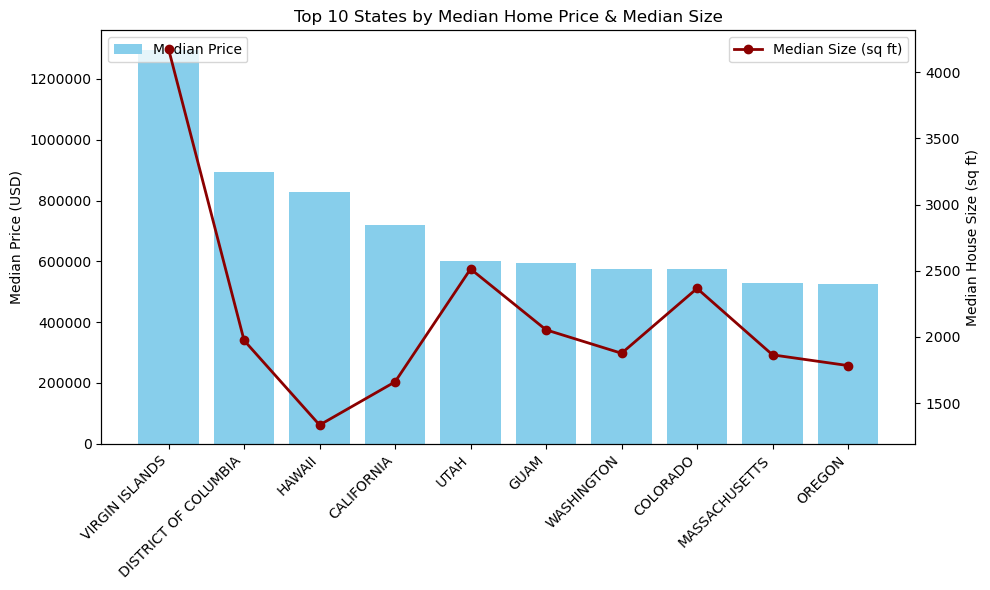

In [7]:
# =========================
# Compare Median Price vs Median Size
# =========================

top_states = state_summary.head(10).reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart for median price
bars = ax1.bar(top_states["state"], top_states["median_price"], color="skyblue", label="Median Price")
ax1.set_ylabel("Median Price (USD)")
ax1.ticklabel_format(style="plain", axis="y")  # avoid sci notation
ax1.set_xticklabels(top_states["state"], rotation=45, ha="right")

# Line plot for median size
ax2 = ax1.twinx()
ax2.plot(top_states["state"], top_states["median_size"], color="darkred", marker="o", linewidth=2, label="Median Size (sq ft)")
ax2.set_ylabel("Median House Size (sq ft)")

# Titles & legends
plt.title("Top 10 States by Median Home Price & Median Size")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


/var/folders/rm/p0jvbc851qj1h7yrs_k190_40000gn/T/ipykernel_72673/3690765021.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_states["state"], rotation=45, ha="right")


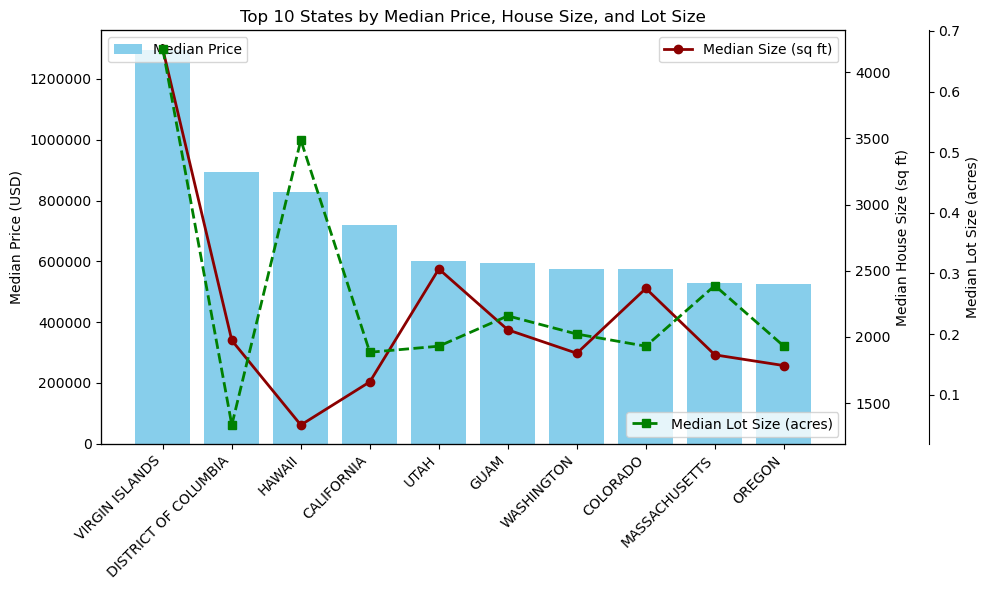

In [9]:
# =========================
# Compare Median Price, Size, and Lot Size
# =========================

top_states = state_summary.head(10).reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart for median price
bars = ax1.bar(top_states["state"], top_states["median_price"], 
               color="skyblue", label="Median Price")
ax1.set_ylabel("Median Price (USD)")
ax1.ticklabel_format(style="plain", axis="y")  # avoid sci notation
ax1.set_xticklabels(top_states["state"], rotation=45, ha="right")

# Line for median house size
ax2 = ax1.twinx()
ax2.plot(top_states["state"], top_states["median_size"], 
         color="darkred", marker="o", linewidth=2, label="Median Size (sq ft)")
ax2.set_ylabel("Median House Size (sq ft)")

# Another y-axis for lot size
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # offset third axis
ax3.plot(top_states["state"], top_states["median_acre"], 
         color="green", marker="s", linewidth=2, linestyle="--", label="Median Lot Size (acres)")
ax3.set_ylabel("Median Lot Size (acres)")

# Titles & legends
plt.title("Top 10 States by Median Price, House Size, and Lot Size")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [11]:
# =========================
# City-Level Summary
# =========================

city_summary = (
    df_clean.groupby(["state", "city"])
    .agg(
        median_price=("price","median"),
        median_bed=("bed","median"),
        median_bath=("bath","median"),
        median_size=("house_size","median"),
        median_acre=("acre_lot","median"),
        count=("price","size")
    )
    .reset_index()
)

# Filter for cities with at least 500 listings for reliability
city_summary = city_summary[city_summary["count"] >= 500]

# Top 15 most expensive cities by median price
top_cities = city_summary.sort_values("median_price", ascending=False).head(15)
print("\nTop 15 Cities by Median Price:\n", top_cities)



Top 15 Cities by Median Price:
             state              city  median_price  median_bed  median_bath  \
2266   CALIFORNIA      Santa Monica     1775000.0         3.0          3.0   
24407  WASHINGTON          Bellevue     1699000.0         4.0          3.0   
2356   CALIFORNIA         Sunnyvale     1695000.0         3.0          3.0   
15709    NEW YORK     New York City     1650000.0         3.0          2.0   
1741   CALIFORNIA            Irvine     1500000.0         4.0          3.0   
24583  WASHINGTON          Kirkland     1400000.0         4.0          3.0   
1619   CALIFORNIA           Fremont     1398000.0         3.0          2.0   
2294   CALIFORNIA      Sherman Oaks     1395000.0         3.0          3.0   
1387   CALIFORNIA          Carlsbad     1295000.0         3.0          3.0   
2232   CALIFORNIA     San Francisco     1295000.0         2.0          2.0   
2238   CALIFORNIA          San Jose     1290000.0         3.0          2.0   
1723   CALIFORNIA  Huntington B

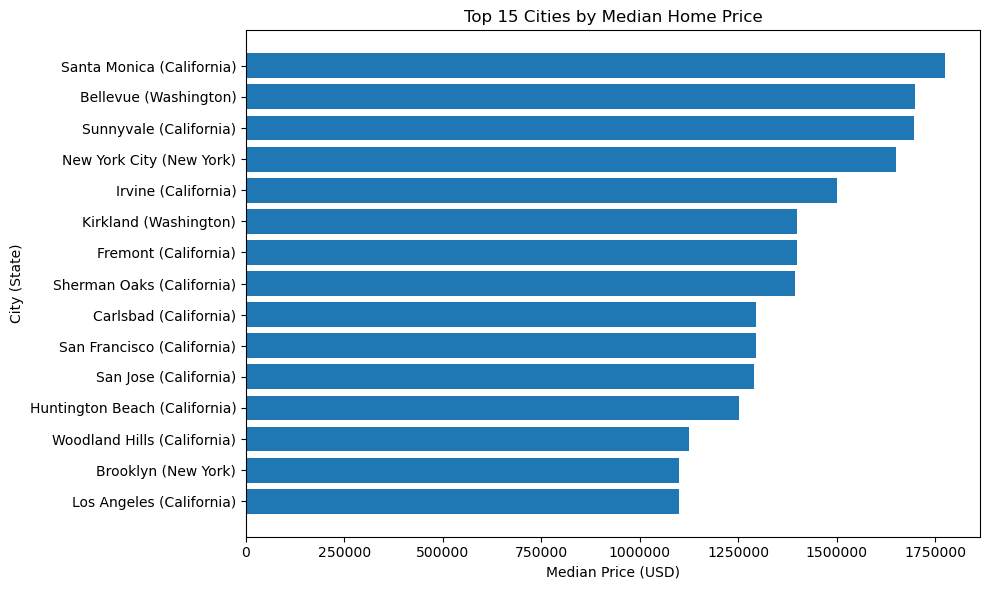

In [16]:
# =========================
# Bar chart: Top 15 Cities by Median Price
# =========================

top_cities_plot = top_cities.copy().reset_index(drop=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(top_cities_plot["city"] + " (" + top_cities_plot["state"].str.title() + ")", 
         top_cities_plot["median_price"])
plt.xlabel("Median Price (USD)")
plt.ylabel("City (State)")
plt.title("Top 15 Cities by Median Home Price")
plt.gca().invert_yaxis()
plt.ticklabel_format(style="plain", axis="x")
plt.tight_layout()
plt.show()


In [18]:
# =========================
# Value view: $/sqft + City vs State Price Ratio
# =========================

# City $/sqft (median_price / median_size)
city_value = city_summary.copy()
city_value = city_value[city_value["median_size"].gt(0)]
city_value["median_price_per_sqft"] = city_value["median_price"] / city_value["median_size"]

# State medians for join
state_meds = (
    df_clean.groupby("state")
      .agg(state_median_price=("price","median"),
           state_median_ppsf=("house_size", lambda s: np.nan),)  # placeholder
      .reset_index()
)

# Compute state median $/sqft safely
state_ppsf = (
    df_clean[df_clean["house_size"].gt(0)]
      .assign(ppsf = df_clean["price"] / df_clean["house_size"])
      .groupby("state")["ppsf"].median()
      .rename("state_median_ppsf")
      .reset_index()
)
state_meds = state_meds.drop(columns=["state_median_ppsf"]).merge(state_ppsf, on="state", how="left")

# Attach state medians
city_value = city_value.merge(state_meds, on="state", how="left")

# City/State price ratio
city_value["city_vs_state_price_ratio"] = city_value["median_price"] / city_value["state_median_price"]

# Show:
# 1) Top 15 cities (from your list) with $/sqft and ratio
view_top15 = city_value.merge(
    top_cities[["state","city"]],
    on=["state","city"],
    how="inner"
).sort_values("median_price", ascending=False)

cols_show = ["state","city","median_price","median_size","median_price_per_sqft","city_vs_state_price_ratio","count"]
print("\nTop 15 Cities — Value Lens:\n", view_top15[cols_show])

# 2) Among all cities (count >= 1000), best $/sqft (lowest) — potential value markets
value_cities = (
    city_value[city_value["count"] >= 1000]
      .sort_values("median_price_per_sqft")
      .head(15)[["state","city","median_price","median_size","median_price_per_sqft","count"]]
)
print("\nPotential Value Cities (count ≥ 1000, lowest $/sqft):\n", value_cities)



Top 15 Cities — Value Lens:
          state              city  median_price  median_size  \
7   CALIFORNIA      Santa Monica     1775000.0       1565.0   
13  WASHINGTON          Bellevue     1699000.0       2640.0   
9   CALIFORNIA         Sunnyvale     1695000.0       1600.0   
12    NEW YORK     New York City     1650000.0       1500.0   
3   CALIFORNIA            Irvine     1500000.0       2326.0   
14  WASHINGTON          Kirkland     1400000.0       2290.0   
1   CALIFORNIA           Fremont     1398000.0       1552.0   
8   CALIFORNIA      Sherman Oaks     1395000.0       1860.0   
0   CALIFORNIA          Carlsbad     1295000.0       1957.0   
5   CALIFORNIA     San Francisco     1295000.0       1378.0   
6   CALIFORNIA          San Jose     1290000.0       1554.5   
2   CALIFORNIA  Huntington Beach     1252500.0       1860.0   
10  CALIFORNIA    Woodland Hills     1125000.0       1928.5   
11    NEW YORK          Brooklyn     1100000.0       1984.0   
4   CALIFORNIA       Los 

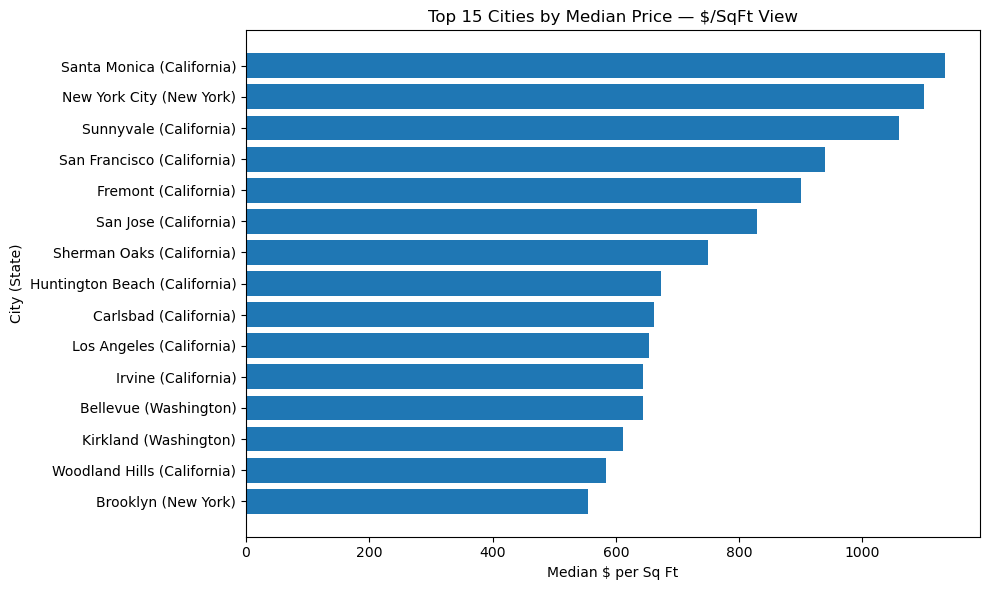

In [20]:
# =========================
# Plot $/sqft for the Top 15 Cities
# =========================

ppsf_plot = view_top15.sort_values("median_price_per_sqft", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.barh(ppsf_plot["city"] + " (" + ppsf_plot["state"].str.title() + ")", 
         ppsf_plot["median_price_per_sqft"])
plt.xlabel("Median $ per Sq Ft")
plt.ylabel("City (State)")
plt.title("Top 15 Cities by Median Price — $/SqFt View")
plt.gca().invert_yaxis()
plt.ticklabel_format(style="plain", axis="x")
plt.tight_layout()
plt.show()



Median Price by Year (National):
     year     price
0   1901  339000.0
1   1904  249900.0
2   1905  405000.0
3   1909  267950.0
4   1910  269000.0
..   ...       ...
79  2021  350000.0
80  2022  380000.0
81  2023  491990.0
82  2024  409000.0
83  2026  235000.0

[84 rows x 2 columns]


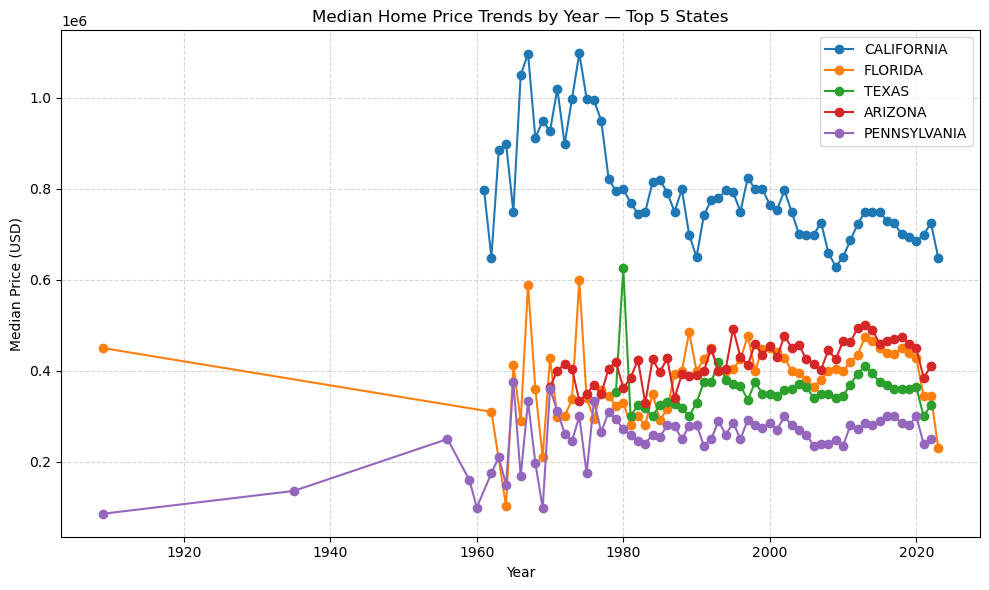

In [22]:
# =========================
# Price Trends Over Time
# =========================

# Keep only rows with a valid previous sold date + price
sales_trend = df_clean.dropna(subset=["prev_sold_date", "price"]).copy()

# Extract year-month
sales_trend["year"] = sales_trend["prev_sold_date"].dt.year
sales_trend["month"] = sales_trend["prev_sold_date"].dt.to_period("M")

# 1) National median price by year
price_trend_year = (
    sales_trend.groupby("year")["price"]
    .median()
    .reset_index()
    .sort_values("year")
)

print("\nMedian Price by Year (National):\n", price_trend_year)

# 2) State-level trend (example: top 5 states by volume)
top_states = (
    sales_trend["state"].value_counts().head(5).index.tolist()
)

state_trend = (
    sales_trend[sales_trend["state"].isin(top_states)]
    .groupby(["year","state"])["price"]
    .median()
    .reset_index()
)

# 3) Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for st in top_states:
    subset = state_trend[state_trend["state"] == st]
    plt.plot(subset["year"], subset["price"], marker="o", label=st)

plt.xlabel("Year")
plt.ylabel("Median Price (USD)")
plt.title("Median Home Price Trends by Year — Top 5 States")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



National Monthly Median Price (first 12 rows):
    year_month     price  rolling_12m
0  1901-01-01  339000.0          NaN
1  1904-03-01  249900.0          NaN
2  1905-07-01  405000.0          NaN
3  1909-01-01   85900.0          NaN
4  1909-03-01  450000.0          NaN
5  1910-01-01  269000.0          NaN
6  1935-08-01  135900.0          NaN
7  1939-11-01  145000.0          NaN
8  1941-09-01  164000.0          NaN
9  1949-03-01  429900.0          NaN
10 1950-04-01  450000.0          NaN
11 1950-10-01  125000.0     259450.0


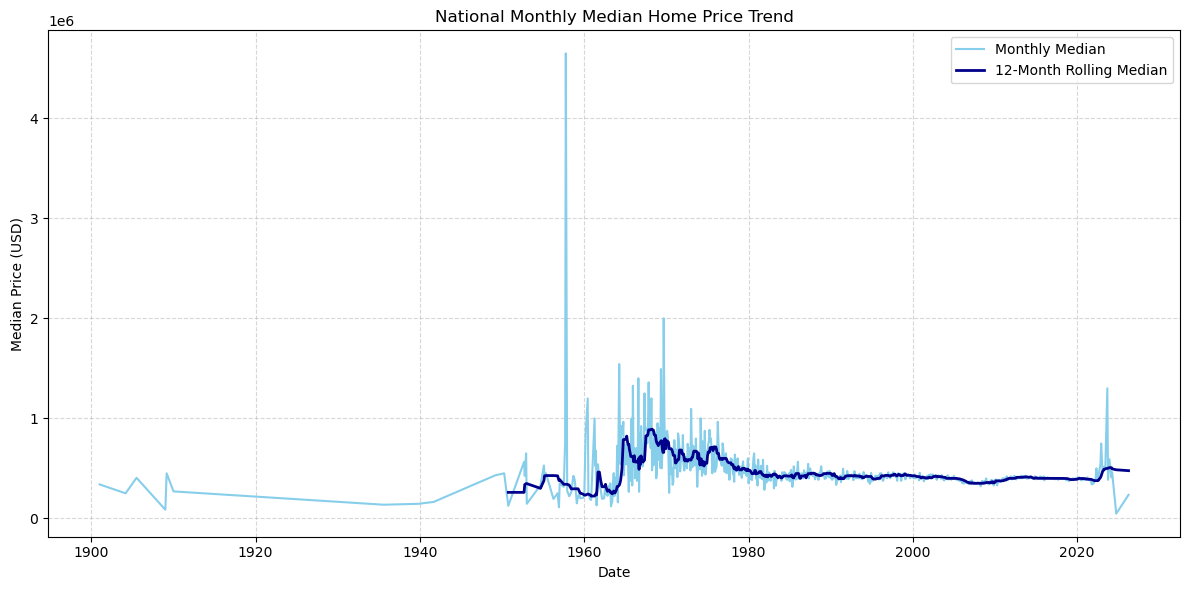

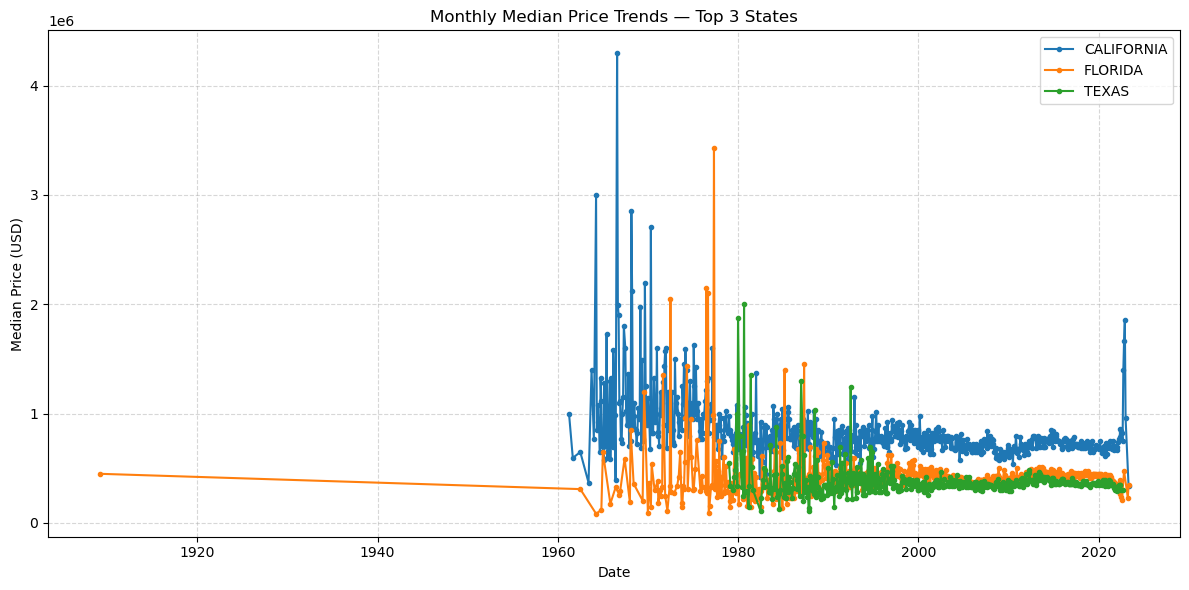

In [24]:
# =========================
# Monthly Rolling Trends
# =========================

# Keep rows with valid sale date + price
sales_trend = df_clean.dropna(subset=["prev_sold_date", "price"]).copy()

# Extract year-month (Period to group by months)
sales_trend["year_month"] = sales_trend["prev_sold_date"].dt.to_period("M")

# National monthly median price
monthly_trend = (
    sales_trend.groupby("year_month")["price"]
    .median()
    .reset_index()
)
monthly_trend["year_month"] = monthly_trend["year_month"].dt.to_timestamp()

# Add 12-month rolling median for smoothing
monthly_trend["rolling_12m"] = monthly_trend["price"].rolling(window=12).median()

print("\nNational Monthly Median Price (first 12 rows):\n", monthly_trend.head(12))

# ---- Plot National Trend ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_trend["year_month"], monthly_trend["price"], color="skyblue", label="Monthly Median")
plt.plot(monthly_trend["year_month"], monthly_trend["rolling_12m"], color="darkblue", linewidth=2, label="12-Month Rolling Median")
plt.xlabel("Date")
plt.ylabel("Median Price (USD)")
plt.title("National Monthly Median Home Price Trend")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---- State-Level Monthly Trends (Top 3 by volume) ----
top_states = sales_trend["state"].value_counts().head(3).index.tolist()

state_monthly = (
    sales_trend[sales_trend["state"].isin(top_states)]
    .groupby(["year_month","state"])["price"]
    .median()
    .reset_index()
)
state_monthly["year_month"] = state_monthly["year_month"].dt.to_timestamp()

plt.figure(figsize=(12,6))
for st in top_states:
    subset = state_monthly[state_monthly["state"] == st]
    plt.plot(subset["year_month"], subset["price"], marker=".", label=st)

plt.xlabel("Date")
plt.ylabel("Median Price (USD)")
plt.title("Monthly Median Price Trends — Top 3 States")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



National YoY % Change (sample):
    year_month      price  rolling_12m  yoy_pct
12 1952-09-01   564900.0     259450.0    66.64
13 1952-10-01   425000.0     337000.0    70.07
14 1952-12-01   649900.0     347000.0    60.47
15 1953-01-01   145000.0     347000.0    68.80
16 1954-09-01   330000.0     299500.0   -26.67
17 1955-02-01   527900.0     377500.0    96.25
18 1955-03-01   425000.0     425000.0   212.73
19 1955-05-01   450000.0     427450.0   210.34
20 1956-04-01   193500.0     427450.0    17.99
21 1956-10-01   250000.0     425000.0   -41.85
22 1956-12-01   110000.0     377500.0   -75.56
23 1957-01-01   350000.0     387500.0   180.00
24 1957-07-01   315000.0     340000.0   -44.24
25 1957-09-01   749900.0     340000.0    76.45
26 1957-10-01  4650000.0     340000.0   615.49


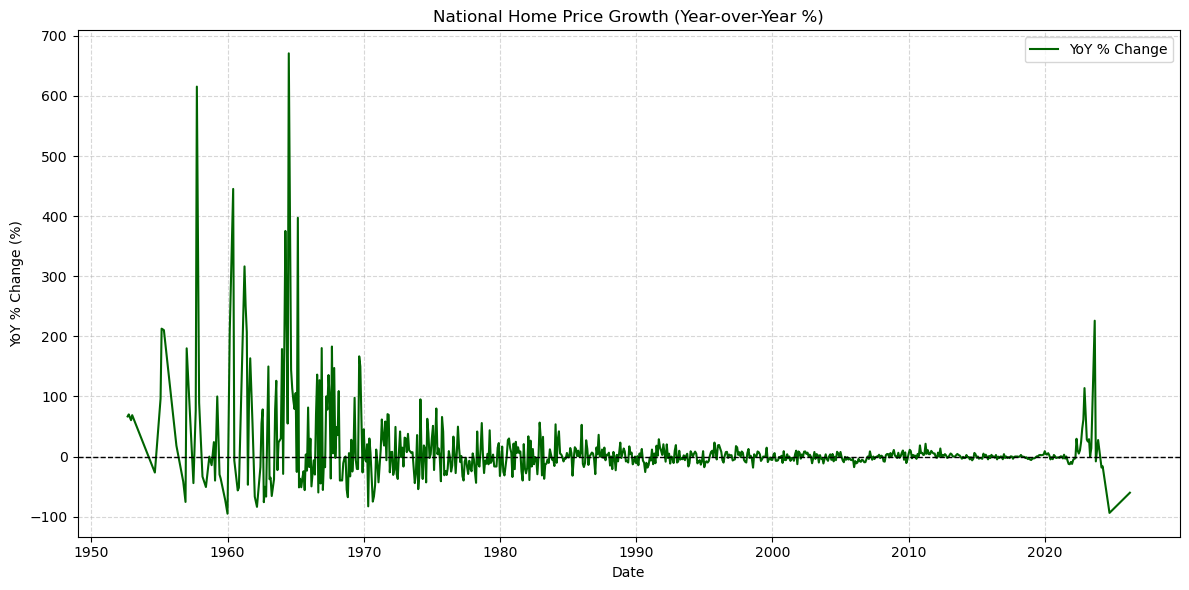

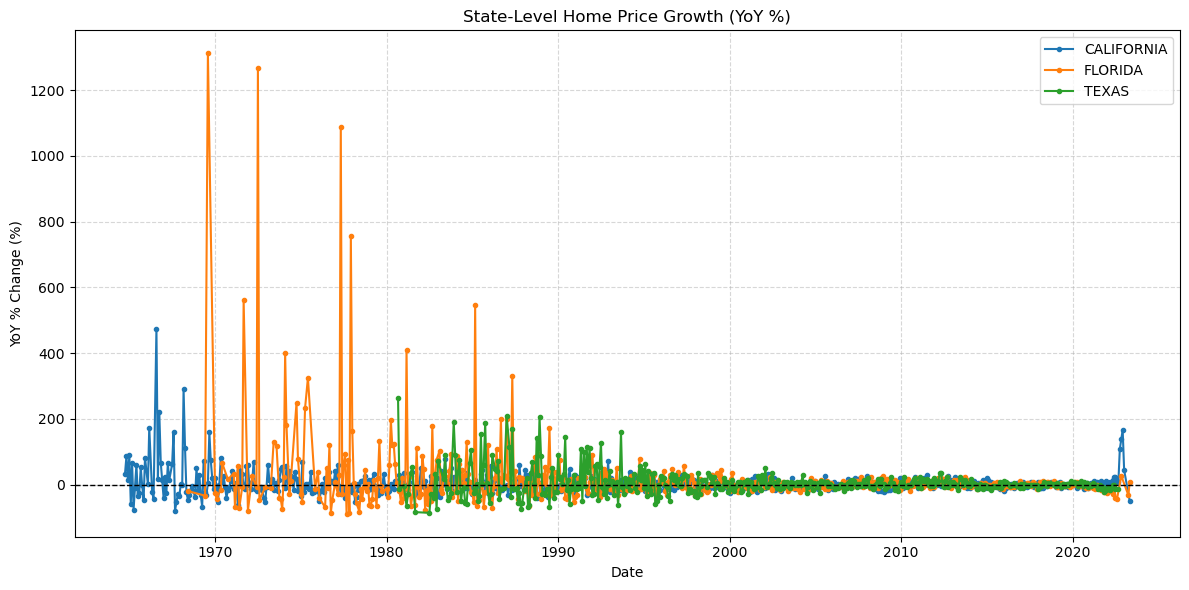

In [26]:
# =========================
# YoY % Change in Median Prices
# =========================

# National YoY (using monthly_trend from before)
monthly_trend["yoy_pct"] = (
    monthly_trend["price"].pct_change(periods=12) * 100
).round(2)

print("\nNational YoY % Change (sample):\n", monthly_trend.dropna().head(15))

# ---- Plot National YoY ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_trend["year_month"], monthly_trend["yoy_pct"], color="darkgreen", label="YoY % Change")
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Date")
plt.ylabel("YoY % Change (%)")
plt.title("National Home Price Growth (Year-over-Year %)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# ---- State-level YoY (Top 3 by volume) ----
state_monthly["yoy_pct"] = (
    state_monthly.groupby("state")["price"].pct_change(periods=12) * 100
).round(2)

plt.figure(figsize=(12,6))
for st in top_states:
    subset = state_monthly[state_monthly["state"] == st]
    plt.plot(subset["year_month"], subset["yoy_pct"], marker=".", label=st)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Date")
plt.ylabel("YoY % Change (%)")
plt.title("State-Level Home Price Growth (YoY %)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


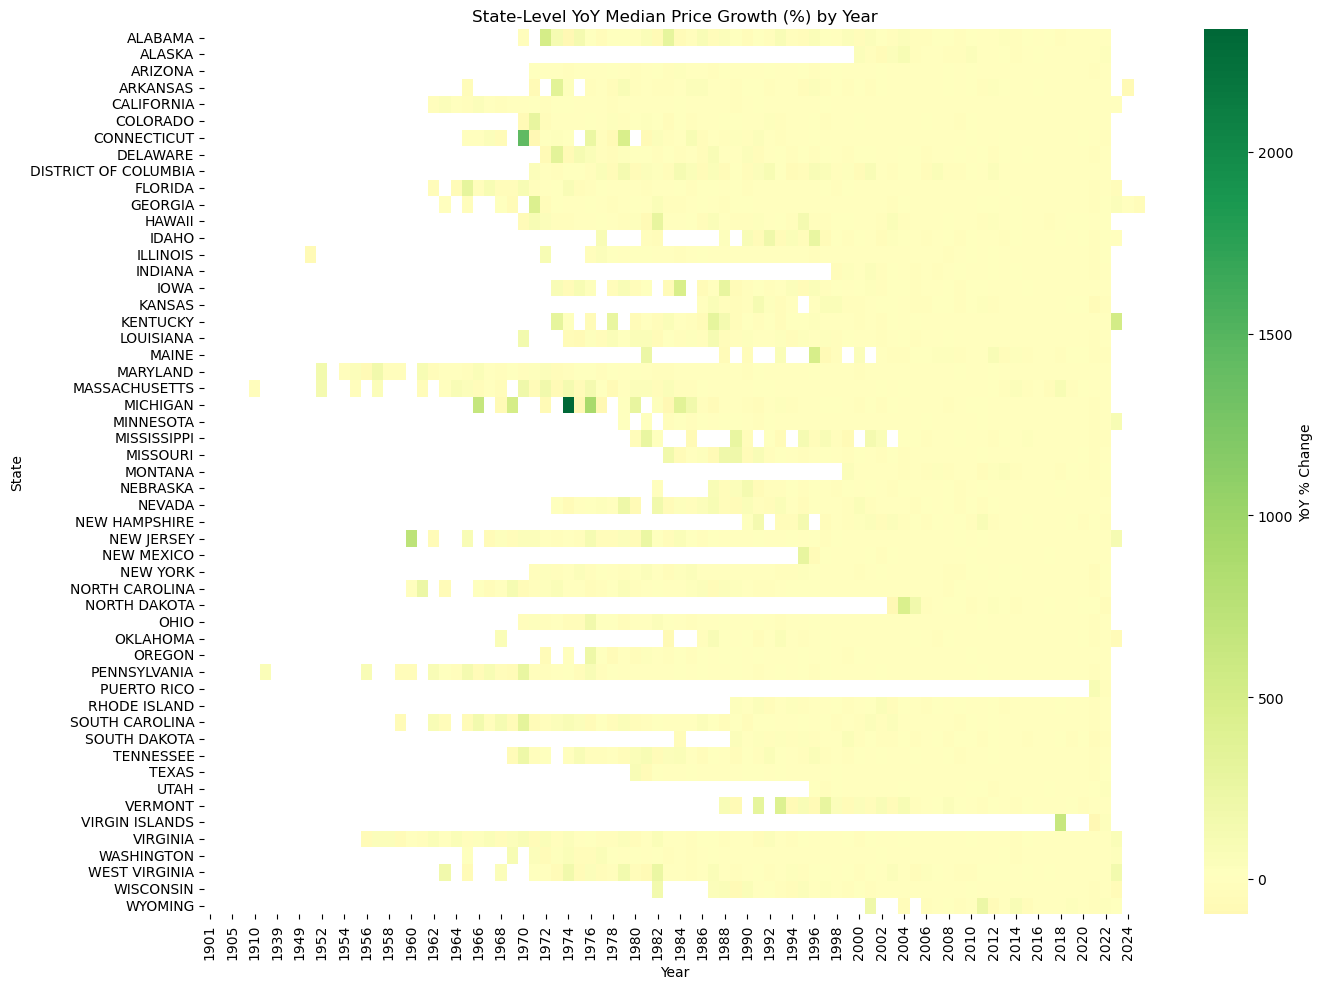

In [28]:
# =========================
# Heatmap of YoY Growth by State × Year
# =========================

import seaborn as sns
import matplotlib.pyplot as plt

# Yearly median price per state
state_year = (
    sales_trend.groupby(["state", sales_trend["prev_sold_date"].dt.year])["price"]
    .median()
    .reset_index()
    .rename(columns={"prev_sold_date": "year"})
)

# Compute YoY % change per state
state_year["yoy_pct"] = (
    state_year.groupby("state")["price"].pct_change() * 100
).round(2)

# Pivot for heatmap
heatmap_data = state_year.pivot(index="state", columns="year", values="yoy_pct")

plt.figure(figsize=(14,10))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    center=0,
    annot=False,
    cbar_kws={"label": "YoY % Change"}
)
plt.title("State-Level YoY Median Price Growth (%) by Year")
plt.xlabel("Year")
plt.ylabel("State")
plt.tight_layout()
plt.show()


In [32]:
# =========================
# Robust YoY Rankings by State × Year
# =========================
from datetime import datetime

CURRENT_YEAR = datetime.now().year  # e.g., 2025
MIN_PER_STATE_YEAR = 200            # tune based on your data volume
TOP_N = 10

# Start from clean sales (has valid dates + price)
sales_trend = df_clean.dropna(subset=["prev_sold_date", "price"]).copy()
sales_trend["year"] = sales_trend["prev_sold_date"].dt.year

# 1) Bound years to realistic range & positive prices
year_min = 1990
mask_years = sales_trend["year"].between(year_min, CURRENT_YEAR)
sales_trend = sales_trend[mask_years & (sales_trend["price"] > 0)]

# 2) Aggregate state-year medians + counts
state_year = (
    sales_trend
    .groupby(["state", "year"])
    .agg(price=("price","median"), n=("price","size"))
    .reset_index()
)

# 3) Enforce minimum sample size per state-year
state_year = state_year[state_year["n"] >= MIN_PER_STATE_YEAR]

# 4) Compute YoY % per state
state_year["yoy_pct"] = (
    state_year.sort_values(["state","year"])
              .groupby("state")["price"]
              .pct_change() * 100
).round(2)

# Helper to list available years
available_years = sorted(state_year["year"].unique().tolist())
print("Available years after cleaning:", available_years)

# 5) Top/Bottom function with guards
def top_bottom_states(yr, top_n=TOP_N):
    df_year = state_year[(state_year["year"] == yr) & (~state_year["yoy_pct"].isna())]
    if df_year.empty:
        return (pd.DataFrame(columns=["state","yoy_pct"]),
                pd.DataFrame(columns=["state","yoy_pct"]))
    # If fewer than top_n states exist, return what’s available
    take = min(top_n, len(df_year))
    top_states = df_year.nlargest(take, "yoy_pct")[["state","yoy_pct"]].reset_index(drop=True)
    bottom_states = df_year.nsmallest(take, "yoy_pct")[["state","yoy_pct"]].reset_index(drop=True)
    return top_states, bottom_states

# 6) Latest year WITH YoY (must also have previous year in data)
yoy_years = sorted(state_year.loc[~state_year["yoy_pct"].isna(), "year"].unique().tolist())
if yoy_years:
    latest_yoy_year = yoy_years[-1]
    top_states, bottom_states = top_bottom_states(latest_yoy_year, TOP_N)
    print(f"\nTop {len(top_states)} States by YoY Growth in {latest_yoy_year}:\n", top_states)
    print(f"\nBottom {len(bottom_states)} States by YoY Growth in {latest_yoy_year}:\n", bottom_states)
else:
    print("\nNo years have valid YoY comparisons after cleaning. Try lowering MIN_PER_STATE_YEAR or year_min.")

# 7) Build per-year summary dict only for years that have YoY data
summary = {}
for yr in yoy_years:
    t, b = top_bottom_states(yr, TOP_N)
    summary[yr] = {"Top": t, "Bottom": b}

# Example safe lookup: pick the latest YoY year if available
if yoy_years:
    year_to_check = yoy_years[-1]
    print(f"\nSummary for {year_to_check}:")
    print("Top:\n", summary[year_to_check]["Top"])
    print("Bottom:\n", summary[year_to_check]["Bottom"])


Available years after cleaning: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Top 1 States by YoY Growth in 2023:
    state  yoy_pct
0  IDAHO    -2.21

Bottom 1 States by YoY Growth in 2023:
    state  yoy_pct
0  IDAHO    -2.21

Summary for 2023:
Top:
    state  yoy_pct
0  IDAHO    -2.21
Bottom:
    state  yoy_pct
0  IDAHO    -2.21


/var/folders/rm/p0jvbc851qj1h7yrs_k190_40000gn/T/ipykernel_72673/1677929577.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(5, "yoy_pct"))
/var/folders/rm/p0jvbc851qj1h7yrs_k190_40000gn/T/ipykernel_72673/1677929577.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nsmallest(5, "yoy_pct"))


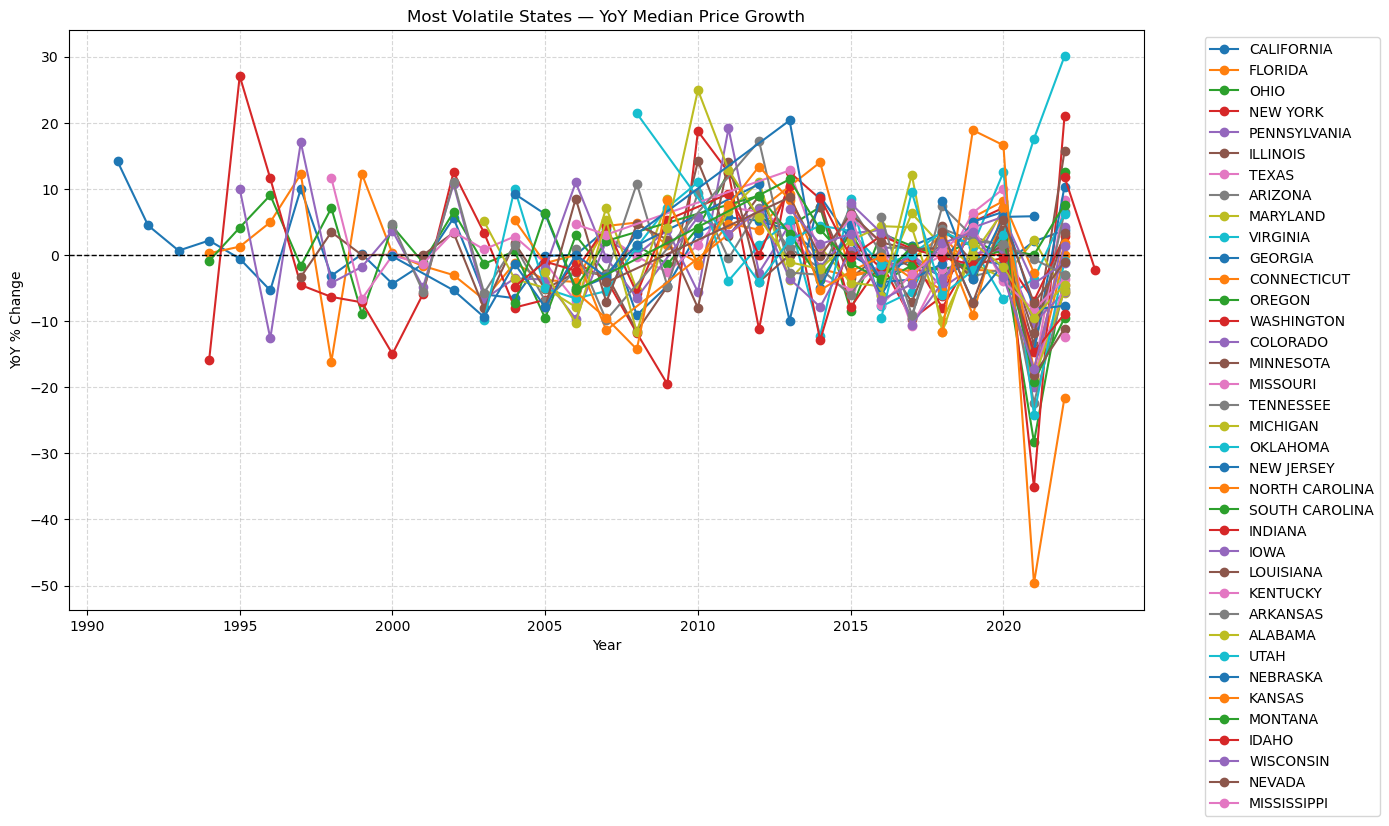

In [34]:
# =========================
# Visualize Top/Bottom States' YoY % Growth Over Time
# =========================

import matplotlib.pyplot as plt

# Keep only valid YoY rows
yoy_data = state_year.dropna(subset=["yoy_pct"]).copy()

# For each year, find top 5 and bottom 5 states
top5_per_year = (
    yoy_data.groupby("year")
    .apply(lambda g: g.nlargest(5, "yoy_pct"))
    .reset_index(drop=True)
)
bottom5_per_year = (
    yoy_data.groupby("year")
    .apply(lambda g: g.nsmallest(5, "yoy_pct"))
    .reset_index(drop=True)
)

# Collect the unique states across all years
volatile_states = pd.concat([top5_per_year["state"], bottom5_per_year["state"]]).unique().tolist()

# Filter data just for those volatile states
volatile_data = yoy_data[yoy_data["state"].isin(volatile_states)]

# ---- Plot ----
plt.figure(figsize=(14,8))
for st in volatile_states:
    subset = volatile_data[volatile_data["state"] == st]
    plt.plot(subset["year"], subset["yoy_pct"], marker="o", label=st)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("YoY % Change")
plt.title("Most Volatile States — YoY Median Price Growth")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/var/folders/rm/p0jvbc851qj1h7yrs_k190_40000gn/T/ipykernel_72673/3000983307.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_per_year = (yoy_data.groupby("year").apply(lambda g: g.nlargest(5, "yoy_pct"))
/var/folders/rm/p0jvbc851qj1h7yrs_k190_40000gn/T/ipykernel_72673/3000983307.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom5_per_year = (yoy_data.groupby("year").apply(lambda g: g.nsmal

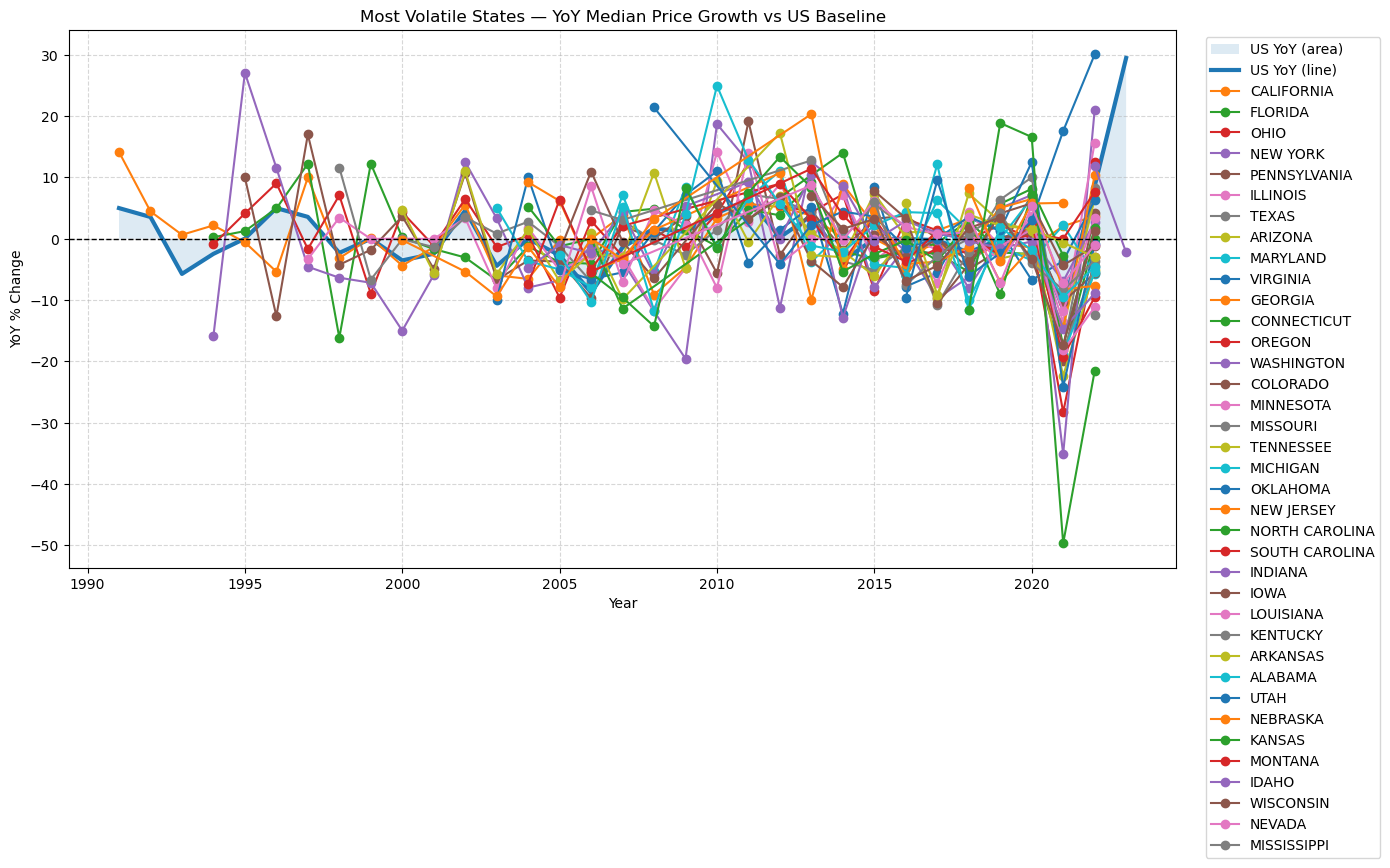

In [36]:
# =========================
# Add National YoY Baseline (Shaded) to Volatility Chart
# =========================

import matplotlib.pyplot as plt

# 1) National yearly median + YoY %
nat_year = (
    sales_trend.groupby("year")["price"].median().reset_index(name="nat_price")
    .sort_values("year")
)
nat_year["nat_yoy_pct"] = (nat_year["nat_price"].pct_change() * 100).round(2)

# 2) Keep only years that appear in the state YoY data
yoy_data = state_year.dropna(subset=["yoy_pct"]).copy()
years = sorted(yoy_data["year"].unique().tolist())
nat_plot = nat_year[nat_year["year"].isin(years)].dropna(subset=["nat_yoy_pct"])

# 3) Volatile states (Top5 & Bottom5 per year) as before
top5_per_year = (yoy_data.groupby("year").apply(lambda g: g.nlargest(5, "yoy_pct"))
                 .reset_index(drop=True))
bottom5_per_year = (yoy_data.groupby("year").apply(lambda g: g.nsmallest(5, "yoy_pct"))
                    .reset_index(drop=True))
volatile_states = pd.concat([top5_per_year["state"], bottom5_per_year["state"]]).unique().tolist()
volatile_data = yoy_data[yoy_data["state"].isin(volatile_states)]

# 4) Plot with national shaded band
plt.figure(figsize=(14,8))

# National YoY shaded band (area vs 0), and bold line
plt.fill_between(nat_plot["year"], 0, nat_plot["nat_yoy_pct"], alpha=0.15, label="US YoY (area)")
plt.plot(nat_plot["year"], nat_plot["nat_yoy_pct"], linewidth=3, label="US YoY (line)")

# Volatile states lines
for st in volatile_states:
    s = volatile_data[volatile_data["state"] == st]
    plt.plot(s["year"], s["yoy_pct"], marker="o", linewidth=1.5, label=st)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("YoY % Change")
plt.title("Most Volatile States — YoY Median Price Growth vs US Baseline")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", ncol=1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
